In [2]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM, GRU
from keras.layers import Dense

import matplotlib as plt
get_ipython().magic(u'matplotlib inline')

import datetime as dt
import itertools
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf

C:\Users\samue\AppData\Local\Temp\ipykernel_22208\706976942.py:7: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


In [3]:
def split_sequence(sequence, n_steps=7, lookahead=0):
    X, y = list(), list()
    for i in range(lookahead,len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i-lookahead:end_ix-lookahead], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

### Data preprocessing

In [4]:
tsdataframe = pd.read_csv('timeseries_lab3.csv')
tsdataframe

,Date,Price
0,1/1/2006,569.865168
1,1/2/2006,593.271930
2,1/3/2006,606.471193
3,1/4/2006,576.932773
4,1/5/2006,573.812500
...,...,...
3647,12/27/2015,832.554167
3648,12/28/2015,880.513919
3649,12/29/2015,856.883910
3650,12/30/2015,888.002212


In [5]:
tsdata = np.load('timeseries_lab3.npy')

In [6]:
tsdata

array([569.86516854, 593.27192983, 606.47119342, ..., 856.88391039,
       888.00221239, 918.49879518])

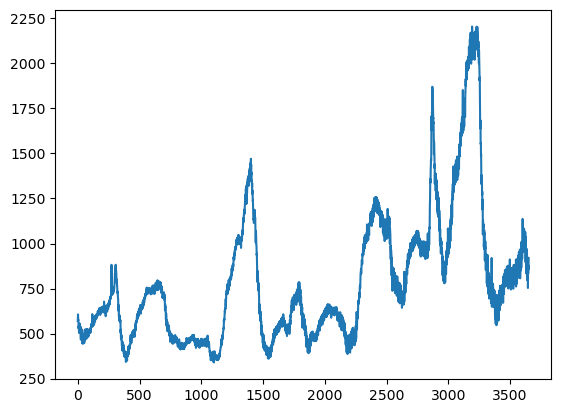

In [7]:
plt.plot(tsdata)

In [8]:
n_steps=7
n_features = 1
train_size = 2557

In [9]:
X, y = split_sequence(tsdata,n_steps)

In [10]:
X

array([[569.86516854, 593.27192983, 606.47119342, ..., 573.8125    ,
        576.17699115, 548.16748768],
       [593.27192983, 606.47119342, 576.93277311, ..., 576.17699115,
        548.16748768, 528.13043478],
       [606.47119342, 576.93277311, 573.8125    , ..., 548.16748768,
        528.13043478, 543.19517544],
       ...,
       [876.92110454, 923.34583333, 807.89142857, ..., 865.42385787,
        832.55416667, 880.51391863],
       [923.34583333, 807.89142857, 753.03703704, ..., 832.55416667,
        880.51391863, 856.88391039],
       [807.89142857, 753.03703704, 865.42385787, ..., 880.51391863,
        856.88391039, 888.00221239]])

In [11]:
X = X.reshape((X.shape[0], X.shape[1], n_features))
trainX = X[:train_size]
trainy = y[:train_size]
testX = X[train_size:]
testy = y[train_size:]

In [12]:
trainX[0]

array([[569.86516854],
       [593.27192983],
       [606.47119342],
       [576.93277311],
       [573.8125    ],
       [576.17699115],
       [548.16748768]])

### LSTM model for time series prediction

In [13]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [14]:
model.fit(trainX, trainy, epochs=20, verbose=1)

Epoch 1/20
80/80 [==============================] - 4s 17ms/step - loss: 85620.2891
Epoch 2/20
80/80 [==============================] - 1s 16ms/step - loss: 696.8395
Epoch 3/20
80/80 [==============================] - 1s 18ms/step - loss: 616.3602
Epoch 4/20
80/80 [==============================] - 1s 18ms/step - loss: 618.9208
Epoch 5/20
80/80 [==============================] - 1s 19ms/step - loss: 630.6581
Epoch 6/20
80/80 [==============================] - 2s 19ms/step - loss: 647.9551
Epoch 7/20
80/80 [==============================] - 1s 19ms/step - loss: 630.1905
Epoch 8/20
80/80 [==============================] - 2s 19ms/step - loss: 625.9268
Epoch 9/20
80/80 [==============================] - 2s 20ms/step - loss: 618.6486
Epoch 10/20
80/80 [==============================] - 2s 19ms/step - loss: 645.3029
Epoch 11/20
80/80 [==============================] - 2s 20ms/step - loss: 647.5797
Epoch 12/20
80/80 [==============================] - 1s 19ms/step - loss: 630.7380
Epoch 13/20

### Prediction (test set)

In [15]:
yhat = model.predict(testX, verbose=0)

In [16]:
pred = []
for i in range(yhat.shape[0]):
    pred.append(yhat[i])
pred = np.array(pred)

Text(0.5, 0, 'Days')

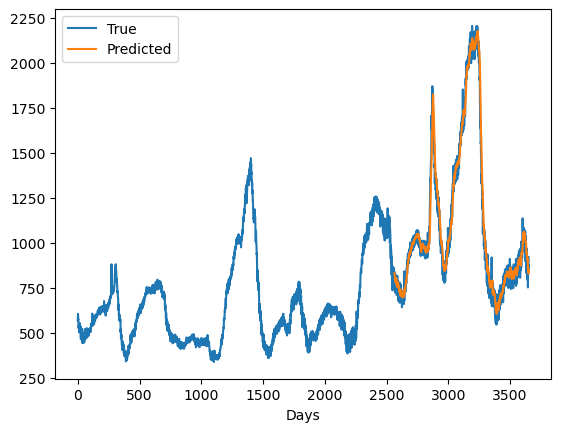

In [17]:
plt.plot(range(len(tsdata)),tsdata,label='True')
plt.plot(range(len(tsdata)-len(testy),len(tsdata)),pred,label='Predicted')
plt.legend(loc='upper left')
plt.xlabel('Days')



## Lab 4: Language Model

<b>Problem statement:</b> Use the following dataset containing element names to train a language model. Generate new names using the trained model. The generated names should resemble element names, e.g. ends with '-ium'

### Data

In [34]:
data = open('elements.txt', 'r').read()
data = data.lower()
vocab = sorted(set(data))
data_size, vocab_size = len(data), len(vocab)
chars = tf.strings.unicode_split(data.split('\n'), 'UTF-8')
data = data.replace('\n', '\n ').split(' ')
data[:5]

['hydrogen\n', 'helium\n', 'lithium\n', 'beryllium\n', 'boron\n']

In [35]:
max_len = len(max(data, key=len))
x, y = [], []

for word in data:
    tmp = (max_len - len(word)) * '0' + word
    x.append(tmp)
    y.append('')
    for i, j in enumerate(word):
        if (i >= len(word) - 1):
            break
        tmp = (max_len - len(word[:-1-i])) * '0' + word[:-1-i]
        x.append(tmp)
        y.append(word[-1-i])

In [36]:
ids_from_chars = keras.layers.StringLookup(vocabulary=list(vocab), mask_token=None)
chars_from_ids = tf.keras.layers.StringLookup(vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)
train_x = np.zeros((len(x), max_len, len(vocab)), dtype=bool)
train_y = np.zeros((len(x), len(vocab)), dtype=bool)
for i, seq in enumerate(x):
    for j, c in enumerate(seq):
        if c != '0':
            train_x[i, j, ids_from_chars(c).numpy()-1] = 1
    train_y[i, ids_from_chars(y[i]).numpy()-1] = 1

### Model Architecture

<img src="./rnn_langmod.png" style="width:500;height:300px;">

In [37]:
model = Sequential()
model.add(LSTM(64, input_shape=(max_len, vocab_size)))
model.add(Dense(vocab_size, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy')

In [38]:
model.fit(train_x, train_y, epochs=20, verbose=1)

Epoch 1/20
33/33 [==============================] - 1s 5ms/step - loss: 3.1142
Epoch 2/20
33/33 [==============================] - 0s 5ms/step - loss: 2.7069
Epoch 3/20
33/33 [==============================] - 0s 5ms/step - loss: 2.5055
Epoch 4/20
33/33 [==============================] - 0s 5ms/step - loss: 2.3263
Epoch 5/20
33/33 [==============================] - 0s 5ms/step - loss: 2.2073
Epoch 6/20
33/33 [==============================] - 0s 5ms/step - loss: 2.1168
Epoch 7/20
33/33 [==============================] - 0s 5ms/step - loss: 2.0335
Epoch 8/20
33/33 [==============================] - 0s 5ms/step - loss: 1.9647
Epoch 9/20
33/33 [==============================] - 0s 5ms/step - loss: 1.9080
Epoch 10/20
33/33 [==============================] - 0s 5ms/step - loss: 1.8550
Epoch 11/20
33/33 [==============================] - 0s 5ms/step - loss: 1.8140
Epoch 12/20
33/33 [==============================] - 0s 5ms/step - loss: 1.7666
Epoch 13/20
33/33 [==============================

In [48]:
base = ["co", "rul", "mar", "ta", "pur", "bum", "daz", "latiss", "k", "q", "m", ""]
results = []
for i in base:
    seq = ('{0:0>' + str(max_len)+'}').format(i).lower()
    new_word = i
    
    while (len(new_word) < max_len):
        # Vectorize the input of the model.
        x_pred = np.zeros((1, max_len, vocab_size))
        for j, c in enumerate(seq):
            if c != '0' and j < x_pred.shape[1]:
                x_pred[0, j, ids_from_chars(c)-1] = 1

        # Predict the probabilities of the next char.
        preds = model.predict(x_pred, verbose=0)[0]

        # Softmax
        preds = np.exp(preds) / np.sum(np.exp(preds))
        next_index = np.where(preds == max(preds))[0][0]
        next_char = chars_from_ids(next_index+1).numpy().decode('utf-8')

        if next_char == '\n' or len(new_word) > max_len:
            break
        else:
            # Append the character
            new_word += next_char
            # Add pre-padding of zeros to the sequence generated and continue.
            seq = ('{0:0>' + str(max_len) + '}').format(new_word).lower()
    results.append(new_word)

for i in range(len(base)):
    print(f"Input Letters: {base[i]}\t |\t New Element: {results[i]}")

Input Letters: co	 |	 New Element: conium
Input Letters: rul	 |	 New Element: rulium
Input Letters: mar	 |	 New Element: marium
Input Letters: ta	 |	 New Element: tanium
Input Letters: pur	 |	 New Element: puronium
Input Letters: bum	 |	 New Element: bumium
Input Letters: daz	 |	 New Element: dazium
Input Letters: latiss	 |	 New Element: latissium
Input Letters: k	 |	 New Element: kerium
Input Letters: q	 |	 New Element: qanium
Input Letters: m	 |	 New Element: manium
Input Letters: 	 |	 New Element: alium


### References:

https://www.tensorflow.org/text/tutorials/text_generation#build_the_model

https://medium.com/analytics-vidhya/business-name-generator-with-tensorflow-eba86c35d9cf